In [1]:
from pycaret.time_series import *
import pandas as pd

df = pd.read_csv("province/data_eng_day.csv", parse_dates=["timestamp"], index_col="timestamp")
# df.index = df.index.normalize()
df = df.drop(columns=["Unnamed: 0"])

print(df.index.duplicated().sum())  # นับจำนวน index ที่ซ้ำกัน
print(df.index[df.index.duplicated()])  # แสดงค่าที่ซ้ำ
df = df[~df.index.duplicated(keep="last")]
df = df.asfreq("D")  # ตั้งค่าความถี่เป็นรายวัน
df = df.interpolate()

# ตรวจสอบข้อมูลอีกครั้ง
print("จำนวน index ที่ซ้ำกันหลังจากแก้ไข:", df.index.duplicated().sum())
print("Index เป็น unique หรือไม่:", df.index.is_unique)

# แปลงคอลัมน์ timestamp ให้เป็น DatetimeIndex หากยังไม่ได้ทำ
df.index = pd.to_datetime(df.index)
# ตรวจสอบให้แน่ใจว่าไม่มีคอลัมน์ที่ไม่ต้องการ
df = df[['pm_2_5', 'humidity', 'pm_10', 'temperature']]  # ใช้เฉพาะคอลัมน์ที่ต้องการ

# ลองเรียกใช้งาน setup อีกครั้ง
train_size = int(len(df))-7
train_df = df.iloc[:train_size]  # ใช้ข้อมูลก่อนหน้าทั้งหมดเป็น train set
test_df = df.iloc[train_size:]  
train_df.index = train_df.index.to_period("D")
test_df.index = test_df.index.to_period("D")
print(len(train_df), len(test_df))
df

0
DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq=None)
จำนวน index ที่ซ้ำกันหลังจากแก้ไข: 0
Index เป็น unique หรือไม่: True
676 7


,pm_2_5,humidity,pm_10,temperature
timestamp,,,,
2023-04-01 07:00:00,4.727273,73.861694,4.727273,30.189449
2023-04-02 07:00:00,9.656243,70.867094,10.386819,30.042296
2023-04-03 07:00:00,14.585213,67.872493,16.046366,29.895143
2023-04-04 07:00:00,11.938022,62.995952,13.300139,33.853401
2023-04-05 07:00:00,10.733566,59.482051,11.864336,35.772219
...,...,...,...,...
2025-02-07 07:00:00,29.321219,70.933952,34.743259,28.271927
2025-02-08 07:00:00,26.000000,69.348548,30.654249,28.385596
2025-02-09 07:00:00,24.616898,69.916384,28.971065,28.373742


In [3]:


# ตั้งค่า PyCaret สำหรับตัวแปร exogenous
exp1 = setup(data=train_df, target='humidity')

# เลือกโมเดลที่ดีที่สุด
best_model_exog = compare_models()

# พยากรณ์ exogenous variable 7 วันข้างหน้า
future_exog = predict_model(best_model_exog, fh=7)


,Description,Value
0,session_id,3342
1,Target,humidity
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(676, 4)"
5,Transformed data shape,"(676, 4)"
6,Transformed train set shape,"(675, 4)"
7,Transformed test set shape,"(1, 4)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.4801,0.3532,3.3343,3.3343,0.0495,0.0481,0.0600
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.5299,0.3899,3.6821,3.6821,0.0552,0.0535,0.0633
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.6808,0.5009,4.7314,4.7314,0.0713,0.0673,56.8233
arima,ARIMA,0.7203,0.5300,5.0022,5.0022,0.0740,0.0711,1.2000
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.7487,0.5509,5.2002,5.2002,0.0772,0.0739,0.1333
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.7876,0.5795,5.4707,5.4707,0.0813,0.0774,0.0567
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.8194,0.6029,5.6908,5.6908,0.0844,0.0806,0.2833
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.8306,0.6112,5.7685,5.7685,0.0855,0.0816,0.0900
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.8306,0.6112,5.7685,5.7685,0.0855,0.0816,0.0533
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.8384,0.6169,5.8228,5.8228,0.0863,0.0823,0.4767


In [20]:
# ตั้งค่า PyCaret สำหรับตัวแปรหลัก โดยใช้ตัวแปร exogenous
train_df2 = train_df[['pm_2_5', 'humidity']]
exp2 = setup(data=train_df2, target="pm_2_5")

# เลือกโมเดลที่ดีที่สุด (รวมถึง ARIMA)
best_model = compare_models()

# พยากรณ์ 7 วันข้างหน้า โดยใช้ exogenous ที่พยากรณ์ไว้
future_pred = predict_model(best_model, fh=7, X=future_exog)


,Description,Value
0,session_id,6121
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(676, 2)"
5,Transformed data shape,"(676, 2)"
6,Transformed train set shape,"(675, 2)"
7,Transformed test set shape,"(1, 2)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
arima,ARIMA,0.5914,0.4413,4.1096,4.1096,0.1273,0.1407,0.0400
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.7755,0.5787,5.3891,5.3891,0.1661,0.1881,0.0333
croston,Croston,0.7922,0.5913,5.5055,5.5055,0.1651,0.1803,0.0133
auto_arima,Auto ARIMA,0.8035,0.5997,5.5840,5.5840,0.1702,0.1889,0.6567
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.8069,0.6022,5.6074,5.6074,0.1708,0.1892,0.0300
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.8069,0.6022,5.6075,5.6075,0.1708,0.1893,0.0300
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.8104,0.6048,5.6314,5.6314,0.1716,0.1901,0.0300
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.8110,0.6052,5.6360,5.6360,0.1718,0.1908,0.0333
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.8240,0.6149,5.7261,5.7261,0.1744,0.1934,0.0300
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,0.8259,0.6163,5.7398,5.7398,0.1758,0.2055,0.0300


In [22]:
exp = setup(data=train_df2, target='pm_2_5',session_id=123)

# สร้างโมเดล Auto ARIMA
auto_arima_model = create_model('auto_arima')

# ทำนาย 7 วันข้างหน้า (ต้องมีค่า X ในอนาคต)
# future_exog = future_exog # ต้องเตรียม exogenous ล่วงหน้า
future_pred = predict_model(auto_arima_model, fh=7, X=future_exog)

print(future_pred)


,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(676, 2)"
5,Transformed data shape,"(676, 2)"
6,Transformed train set shape,"(675, 2)"
7,Transformed test set shape,"(1, 2)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2025-01-31,1.1942,0.8910,8.2993,8.2993,0.2621,0.3016
1,2025-02-01,0.5218,0.3894,3.6255,3.6255,0.1110,0.1175
2,2025-02-02,0.6946,0.5186,4.8272,4.8272,0.1375,0.1477
Mean,NaT,0.8035,0.5997,5.5840,5.5840,0.1702,0.1889
SD,NaT,0.2851,0.2127,1.9817,1.9817,0.0658,0.0806


             y_pred
2025-02-04  31.2697
2025-02-05  28.9142
2025-02-06  26.8632
2025-02-07  24.7433
2025-02-08  24.1302
2025-02-09  22.9675
2025-02-10  22.6967


In [24]:
df.tail(7)


,pm_2_5,humidity,pm_10,temperature
timestamp,,,,
2025-02-05 07:00:00,13.987089,71.500943,16.699531,28.327450
2025-02-06 07:00:00,19.454865,69.511783,23.709261,28.579177
2025-02-07 07:00:00,29.321219,70.933952,34.743259,28.271927
2025-02-08 07:00:00,26.000000,69.348548,30.654249,28.385596
2025-02-09 07:00:00,24.616898,69.916384,28.971065,28.373742
2025-02-10 07:00:00,25.856981,71.226336,30.652667,28.251201
2025-02-11 07:00:00,27.522727,68.159624,32.532955,28.693799


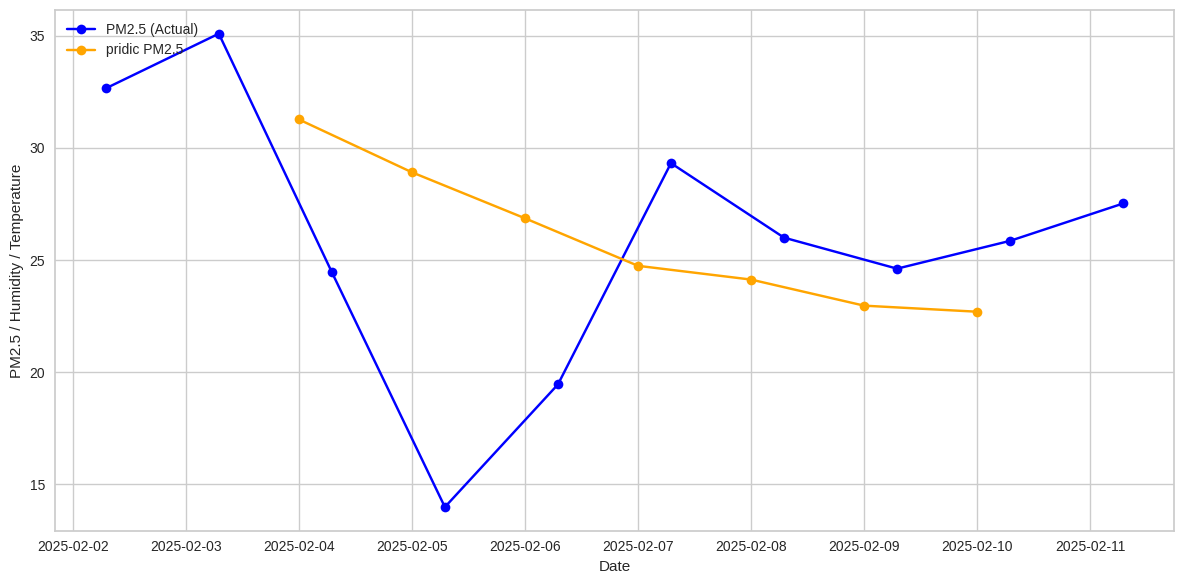

In [25]:
import matplotlib.pyplot as plt

# สร้าง figure และแกน Y แรก
fig, ax1 = plt.subplots(figsize=(12, 6))

# พลอตข้อมูลจาก df บนแกน Y แรก
ax1.plot(df.index[-10:], df['pm_2_5'][-10:], label='PM2.5 (Actual)', color='blue', linestyle='-', marker='o')
# ax1.plot(df.index, df['humidity'], label='Humidity', color='green', linestyle='-', marker='s')
ax1.plot(future_pred.index,future_pred, label='pridic PM2.5', color='orange', linestyle='-', marker='o')

# ตั้งค่าแกน Y แรก
ax1.set_xlabel('Date')
ax1.set_ylabel('PM2.5 / Humidity / Temperature')
ax1.tick_params(axis='y')

# สร้างแกน Y ที่สอง
# ax2 = ax1.twinx()

# พลอตข้อมูลจริงและข้อมูลที่ทำนายบนแกน Y ที่สอง
# ax1.plot(actual_values.index, future_pred, label='Actual PM2.5', color='red', linestyle='--', marker='x')
# ax2.plot(predicted_values.index, predicted_values, label='Predicted PM2.5', color='purple', linestyle='--', marker='d')

# ตั้งค่าแกน Y ที่สอง
# ax2.set_ylabel('PM2.5 (Actual & Predicted)')
# ax2.tick_params(axis='y')

# เพิ่มคำอธิบายเส้น (legend)
lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 , labels1 , loc='upper left')

# เพิ่มกริด
ax1.grid(True)

# ปรับระยะห่างให้เหมาะสม
plt.tight_layout()

# แสดงกราฟ
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
# คำนวณค่า error metrics
# actual_values คือค่าจริงจากข้อมูลทดสอบ (ที่ในที่นี้ใช้ df)
actual_values = df['pm_2_5'][-len(future_pred):]

# predicted_values คือค่าทำนายจาก model
predicted_values = future_pred['y_pred']

# คำนวณค่า error
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

# แสดงผลลัพธ์
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 5.522695852857145
Mean Squared Error (MSE): 61.09504539169435
Root Mean Squared Error (RMSE): 7.816331965295125
R-squared (R2): -1.5268138568261986
